In [5]:
using IonSim
using QuantumOptics
using QuantumOptics: timeevolution, stochastic
import DifferentialEquations
import PyPlot
const plt = PyPlot
using Distributions
using Expectations

In [6]:
# set some plot configs
plt.matplotlib.rc("xtick", top=false)
plt.matplotlib.rc("ytick", right=false, left=false)
plt.matplotlib.rc("axes", labelsize=20, titlesize=20, grid=true)
plt.matplotlib.rc("axes", linewidth=2)
plt.matplotlib.rc("grid", alpha=0.25, linestyle="--")
plt.matplotlib.rc("font", family="Palatino", weight="medium")
plt.matplotlib.rc("figure", figsize=(8,4))
plt.matplotlib.rc("xtick.major", width=2)
plt.matplotlib.rc("ytick.major", width=2)

In [47]:
C = Ca40(["S-1/2", "D-1/2"])
L = Laser()
νa = 1.5e6  # axial trap frequency
νr = 3.0e6    # radial trap frequency
chain = LinearChain(
        ions=[C], com_frequencies=(x=νr,y=νr,z=νa), 
        vibrational_modes=(x=[], y=[], z=[1]))
T = Trap(configuration=chain, B=4e-4, Bhat=ẑ, δB=0, lasers=[L]);
L.k = (x̂ + ẑ)/√2 
L.ϵ = (x̂ - ẑ)/√2;
mode = T.configuration.vibrational_modes.z[1]

┌ Warning: !(ϵ ⟂ k)
└ @ IonSim C:\Users\suman\.julia\packages\IonSim\5Hvou\src\lasers.jl:84


VibrationalMode(ν=1.5e6, axis=ẑ, N=10)

In [53]:
get_η(mode, L, C)

0.05594817754001876

# RAP on RSB transition

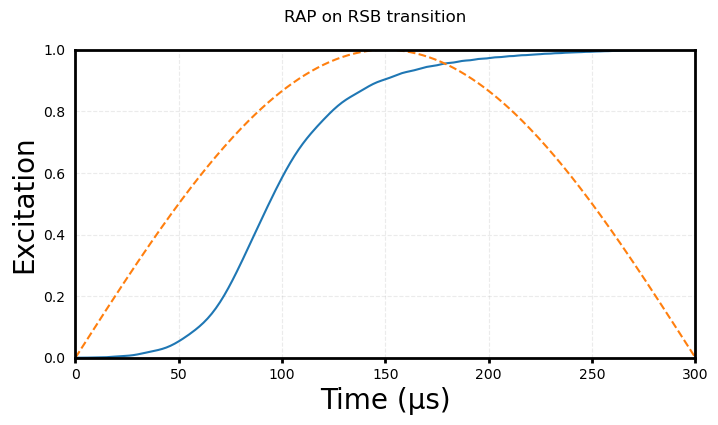

  1.458798 seconds (50.19 M allocations: 1.077 GiB, 8.37% gc time)


PyObject Text(0.5, 0.98, 'RAP on RSB transition')

In [121]:
T.B = 4e-4
Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))
E1 = Efield_from_pi_time(3e-6, T, 1, 1, ("S-1/2", "D-1/2"))

Tp = 300 # the length of time of the frequency chirp in μs
mode.N = 30
ψi_mode = thermalstate(mode, 2)

n̄ = 5
ψi = C["S-1/2"] ⊗ mode[n̄]
#ψi = dm(C["S-1/2"]) ⊗ thermalstate(mode, n̄)

#We’ll linearly sweep through the laser’s frequency from -100 kHz to +100 kHz detuned from the carrier transition in a time Tp
δν = 200e3 #frequency chirp length 300 kHz

# Δϕ is equal to half the detuning range we will chirp the laser over multiplied by the timescale (1e-6)
Δϕ = 2π * (δν/2) * 1e-6

# Set the frequency chirp
L.ϕ = t -> (-Δϕ + (2Δϕ / Tp) * t) * t;

# amplitude Rabi_freq
function Ω(t)
    if t < Tp
        return 2*E1*sin(π*t/Tp) #E*sin(π*t/Tp) #exp(-(t-Tp/2)^2/6000) ; sin(π * t / Tp)^2
    else
        return 0
    end
end
L.E = Ω;
L.Δ  = Δf - mode.ν 


tspan = 0:Tp/300:Tp
h = hamiltonian(T, rwa_cutoff=5e6)
@time tout, ψt = timeevolution.schroedinger_dynamic(tspan, ψi, h, displacement="analytic")

# ψo = ψt[end]  
# p = expect(ionprojector(T, "D-1/2"), ψo)
# print(abs(p))

ex1 = expect(ionprojector(T, "D-1/2"), ψt)
#plt.plot(tspan, ex1)
plt.plot(tout, ex1, label="rwa_cutoff=5e6")

plt.plot(tout, @.(L.E(tout) / (2*E1)), linestyle="--", label="scaled amplitude profile")

plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");
plt.suptitle("RAP on RSB transition")
#plt.legend(loc="lower right", fontsize = 10)

In [7]:
p = expect(ionprojector(T, "D-1/2"), ψt[end])
p = real(p)
# if p > 1
#     p = 1
# elseif p < 0
#     p = 0
# end
B = Bernoulli(p)
rand(B, 1)[1]


true

# theoretical_nbar

In [26]:
# n = one(C) ⊗ thermalstate(mode, 5)
# ψi = dm(C["S-1/2"]) ⊗ dm(mode[5])
# theoretical_nbar = real(expect(n, ψi))

## scaling with fock states |n>; sequence rsb RAP pulse followed by carrier pi pulse

In [76]:
mode.N = 30
n̄ = 5
n = one(C) ⊗ IonSim.number(mode)

T.B = 4e-4
Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))
E1 = Efield_from_pi_time(3e-6, T, 1, 1, ("S-1/2", "D-1/2"))

δν = 200e3
Tp = 300
Δϕ = 2π * (δν/2) * 1e-6

# amplitude Rabi_freq
function Ω(t)
    if t < Tp
        return 2*E1*sin(π*t/Tp) 
    else
        return 0
    end
end

number_of_repetitions = 50
phonon_number_measurement = 0
theoretical_nbar = 0

j = []

for k in 1:number_of_repetitions
    ψi = C["S-1/2"] ⊗ mode[n̄]
    theoretical_nbar = real(expect(n, ψi))
    i = 0
    while true
        # # simulation with RAP pulse on rsb transition

        L.ϕ = t -> (-Δϕ + (2Δϕ / Tp) * t) * t;
        L.E = Ω;
        L.Δ  = Δf - mode.ν 


        tspan = 0:Tp/30:Tp 
        h = hamiltonian(T, rwa_cutoff=5e6)
        tout, ψt = timeevolution.schroedinger_dynamic(tspan, ψi, h, displacement="analytic")

        ψo = ψt[end]

        p = expect(ionprojector(T, "D-1/2"), ψo)
        p = real(p)
        if p > 1
            p = 1
        elseif p < 0
            p = 0
        end
        B = Bernoulli(p)
        b = rand(B, 1)[1]
        if !b
            break
        else
        # simulation with pi pulse on carrier
            L.Δ = Δf
            E1 = Efield_from_pi_time(3e-6, T, 1, 1, ("S-1/2", "D-1/2"))
            L.E = E1
            L.ϕ = 0

            tpi = 3 # length of pi pulse|


            tlist = 0:0.1:tpi
            h = hamiltonian(T, rwa_cutoff=5e6)
            tout, ψt = timeevolution.schroedinger_dynamic(tlist, ψo, h, displacement="analytic")

            ψi = ψt[end]
            push!(j, i)
            i += 1
        end
    end
    phonon_number_measurement += i
    println(phonon_number_measurement)
end

average_phonon_number_measurement = phonon_number_measurement / number_of_repetitions
error = abs(theoretical_nbar - average_phonon_number_measurement) / theoretical_nbar;
println("average: ", average_phonon_number_measurement);
println("theoretical_nbar: ", theoretical_nbar);
println("error: ", error);

5
10
15
20
24
29
34
39
44
49
54
59
64
69
74
79
84
89
94
99
104
109
114
119
124
128
133
138
143
147
152
157
162
167
172
177
182
187
192
196
201
206
211
216
221
226
231
236
241
246
average: 4.92
theoretical_nbar: 5.0
error: 0.016000000000000014


In [73]:
print(j)

Any[0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4]

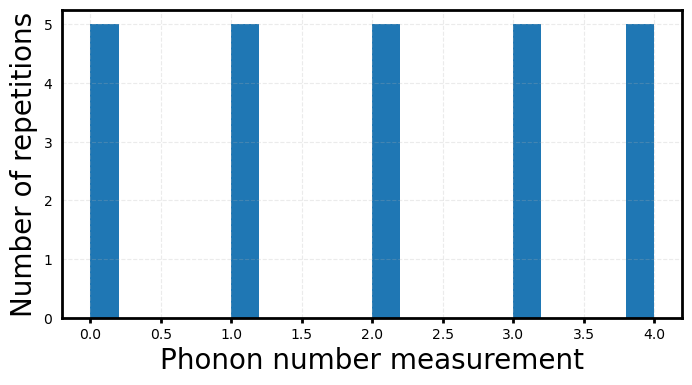

In [74]:
num_bins = 20
n, bins, patches  = plt.hist(j, num_bins)
plt.show()
plt.ylabel("Number of repetitions")
plt.xlabel("Phonon number measurement");

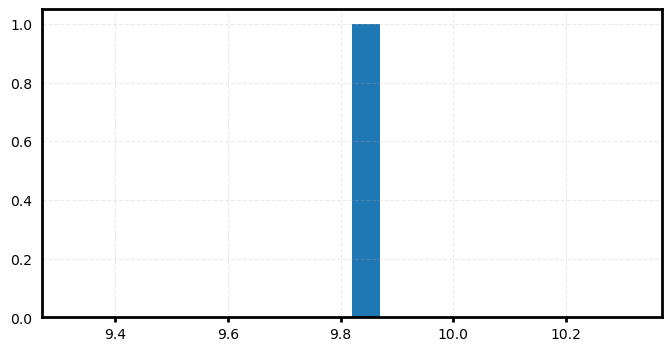

In [28]:
x = average_phonon_number_measurement
num_bins = 20
n, bins, patches  = plt.hist(x, num_bins)
plt.show()

# Error scaling with theoretical n̄

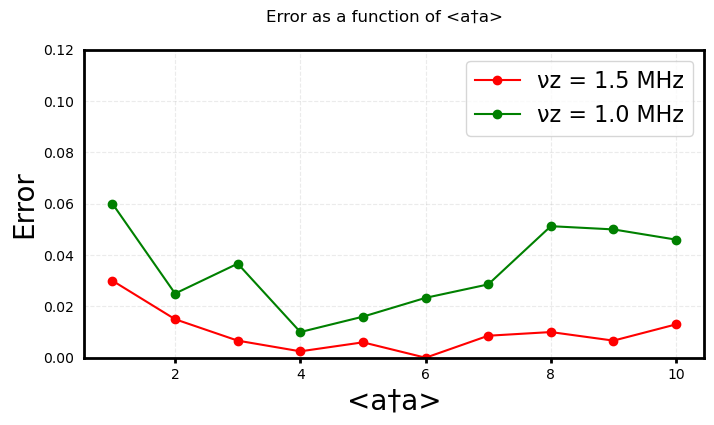

PyObject Text(0.5, 0.98, 'Error as a function of <a†a>')

In [9]:
# rwa_cutoff = 2e6
# number_of_repititions = 100
# Tp = 150
# axial_trap_freq = 1.5e6
# n̄ = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
# theoretical_nbar = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
# average_phonon_number_measurement = [9.91, 8.89, 7.87, 6.93, 5.87, 4.86, 3.87, 2.81, 1.89, 0.89]
# error = [0.00899, 0.01222, 0.01625, 0.01, 0.02166, 0.02799, 0.03249, 0.06333, 0.05500, 0.10999]

rwa_cutoff = 2e6
number_of_repititions = 100
Tp = 300
axial_trap_freq = 1.5e6
n̄ = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
theoretical_nbar = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
average_phonon_number_measurement = [9.87, 8.94, 7.92, 6.94, 6, 4.97, 3.99, 2.98, 1.97, 0.97]
error = [0.013, 0.00666, 0.01, 0.00857, 0, 0.006, 0.00249, 0.00666, 0.015, 0.03]


# rwa_cutoff = 1.5e6
# number_of_repititions = 100
# Tp = 300
# axial_trap_freq = 1e6
# n̄ = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
theoretical_nbar_1 = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
# average_phonon_number_measurement = [9.54, 8.55, 7.59, 6.8, 5.86, 4.92, 3.96, 2.89, 1.95, 0.94]
error_1 = [0.046, 0.04999, 0.05125, 0.02857, 0.02333, 0.016, 0.01, 0.03666, 0.025, 0.06]

plt.plot(theoretical_nbar, error, "ro-", label="νz = 1.5 MHz")
plt.plot(theoretical_nbar_1, error_1, "go-", label="νz = 1.0 MHz")
plt.legend(loc="upper right", fontsize = 16)
plt.ylim(0, 0.12)
plt.ylabel("Error")
plt.xlabel("<a†a>");
plt.suptitle("Error as a function of <a†a>")

### sequence of simulation; pi pulse on carrier followed by bsb RAP pulse

In [30]:
η = abs(get_η(mode, L, C))

0.07105425653011588